<a href="https://colab.research.google.com/github/Oscar-Mo/big_brain_BC/blob/main/basic_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ischemic lesion segmentation in the brain

This is the basic, foundational notebook we used to get us started on our individual experiments. It trains a UNet model on 525 samples of data in batches of 5. Due to GPU and RAM limitations, the samples need to be downsized to 64 x 64 x 64.

-

Credits:

UNet 3D - https://github.com/jphdotam/Unet3D/blob/main/unet3d.py

BCELoss - https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook 

Atlas sample code - https://github.com/npnl/isles_2022/


### Setup
The MRI data is loaded from a dataset in google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install bids
!pip install git+https://github.com/npnl/bidsio
import bidsio
bids_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=5,
                                root_dir='drive/MyDrive/big_brain/split1/train/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 13.9 MB/s 
     |████████████████████████████████| 96 kB 6.4 MB/s 
     |████████████████████████████████| 125 kB 15.8 MB/s 
     |████████████████████████████████| 68 kB 5.4 MB/s 
     |████████████████████████████████| 1.3 MB 65.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=b4a4cb827900c87106226a7c80ca41696d2d95839e9f147639da7379db7a5b80
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.45
    Uninstalling SQLAlchemy-1.4.45:
      Successfully uninstalled SQLAlchemy-1.4.45
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: p

In [4]:
tmp = bids_loader.load_sample(0)
print(f'There are {len(bids_loader)} subjects in our dataset.')
print(f'Every sample loads {len(tmp)} images.')
print(f'Images have these dimensions: {bids_loader.data_shape}')
print(f'Every batch will load {bids_loader.batch_size} samples.')

There are 525 subjects in our dataset.
Every sample loads 2 images.
Images have these dimensions: (197, 233, 189)
Every batch will load 5 samples.


### Model + optimization


In [5]:
import torch
from UNet_model import UNet

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=1, n_classes=1)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Loss

In [12]:
# credit: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

from torch import nn
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

loss_func = DiceBCELoss()

In [7]:
def downsize_64(batch):
  if (len(batch.shape) == 4):
    batch = batch.unsqueeze(0)
  num_samples = batch.shape[0]
  scale = 3
  batch = batch[:,:,::scale,::scale,::scale]
  batch = batch[:,:,:64,:64]
  zeros = torch.zeros(num_samples,1,64,64,1)
  batch = torch.cat((zeros, batch), 4)
  return batch

torch.Size([5, 1, 64, 64, 64])


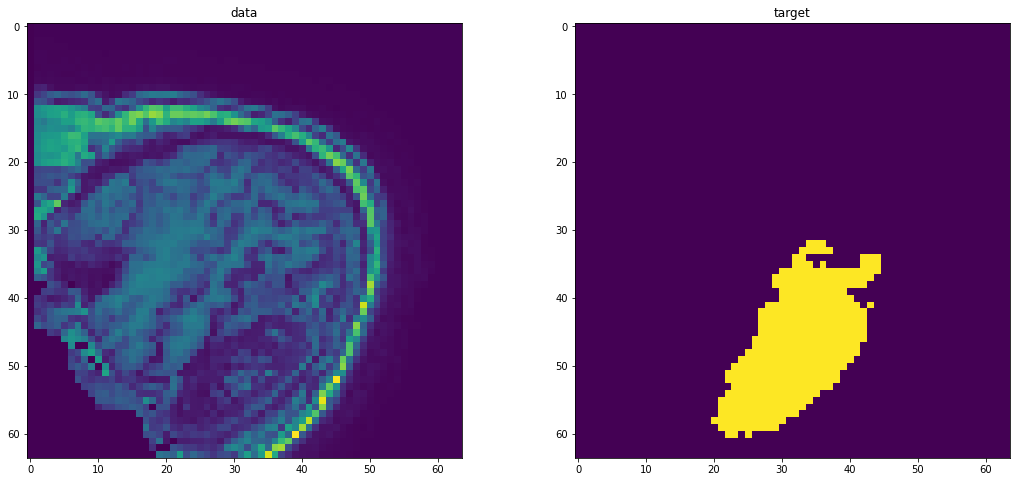

In [8]:
import matplotlib.pyplot as plt

data, target = next(bids_loader.load_batches())
data = torch.Tensor(data)
target = torch.Tensor(target)

plt.figure(figsize=(18, 8)) 
plt.subplot(121)
plt.imshow(downsize_64(data)[0,0,50]);plt.title('data')
plt.subplot(122)
plt.imshow(downsize_64(target)[0,0,50]);plt.title('target')
print(downsize_64(target).shape)

### Training

In [14]:
import matplotlib.pyplot as plt

# model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

i = 0
loss_ls = []
for epoch in range(8):
    running_loss = 0.0
    for data, label in bids_loader.load_batches():

        data = torch.Tensor(data)
        label = torch.Tensor(label)

        data = downsize_64(data).to(device)
        label = downsize_64(label).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(data)
        loss = loss_func(outputs, label)
        loss_ls.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('-', end ="")
        if (i % 10 == 9):
          loss_str = f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10 :.8f}'
          print(loss_str)
          running_loss = 0.0
        i += 1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------[1,    10] loss: 1.15548270
----------[1,    20] loss: 1.13551965
----------[1,    30] loss: 1.13572987
----------[1,    40] loss: 1.12396163
----------[1,    50] loss: 1.11174157
----------[1,    60] loss: 1.10220050
----------[1,    70] loss: 1.09463019
----------[1,    80] loss: 1.09153398
----------[1,    90] loss: 1.06069244
----------[1,   100] loss: 1.05733650
----------[2,   110] loss: 0.53374113
----------[2,   120] loss: 1.04244958
----------[2,   130] loss: 1.04463673
----------[2,   140] loss: 1.06222281
----------[2,   150] loss: 1.06284918
----------[2,   160] loss: 1.02864538
----------[2,   170] loss: 1.03019795
----------[2,   180] loss: 1.03741925
----------[2,   190] loss: 1.00762485
----------[2,   200] loss: 0.96110259
----------[2,   210] loss: 1.00649718
----------[3,   220] loss: 0.99031137
----------[3,   230] loss: 0.92602738
----------[3,   240] loss: 1.03629094
----------[3,   250] loss: 1.02582934
----------[3,   260] loss: 0.99142618
----------[3

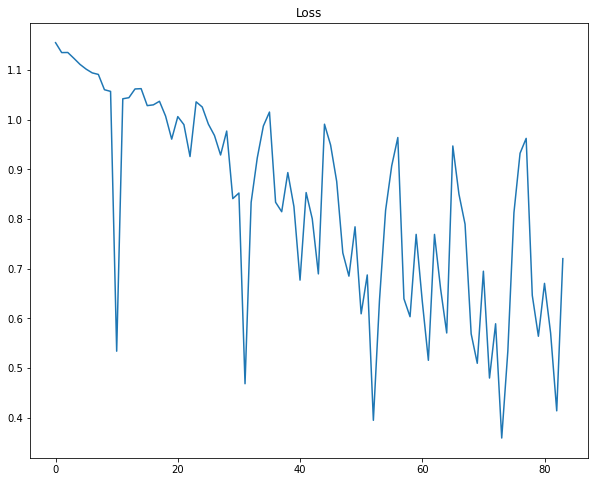

In [7]:
import matplotlib.pyplot as plt

loss_ls = [1.15548270, 1.13551965, 1.13572987, 1.12396163, 1.11174157, 1.10220050, 1.09463019, 1.09153398, 1.06069244, 1.05733650, 0.53374113, 1.04244958, 1.04463673, 1.06222281, 1.06284918, 1.02864538, 1.03019795, 1.03741925, 1.00762485, 0.96110259, 1.00649718, 0.99031137, 0.92602738, 1.03629094, 1.02582934, 0.99142618, 0.96846557, 0.92916641, 0.97739107, 0.84125295, 0.85248368, 0.46818603, 0.83373931, 0.92311503, 0.98758860, 1.01567998, 0.83390735, 0.81482027, 0.89370679, 0.82529165, 0.67699442, 0.85341752, 0.80057505, 0.68952951, 0.99120728, 0.94926407, 0.87568784, 0.73185045, 0.68500323, 0.78442448, 0.60910665, 0.68738447, 0.39446768, 0.63625396, 0.81769733, 0.90725144, 0.96436660, 0.63946716, 0.60325393, 0.76918268, 0.63462652, 0.51539842, 0.76910712, 0.65939522, 0.57047513, 0.94735119, 0.85029742, 0.78977752, 0.56874126, 0.50937476, 0.69498191, 0.47964318, 0.58904491, 0.35875509, 0.53360928, 0.81292865, 0.93259665, 0.96264392, 0.64627191, 0.56385446, 0.67043188, 0.57025877, 0.41356192, 0.72028883]
plt.figure(figsize=(10,8))
plt.title('Loss')
plt.plot(loss_ls)